# Sunset prototyp

## Schritte:
- lade Korpusdaten
- lade Sprachmodell (nehmen wir erstmal FastText, oder?)
- trainiere Sprachmodell
    - Mit FastText war Bürotisch und Erotisch sehr nah anenander, wir nehmen Word2Vec
- wenn das was ist, speicher den kleinen Goblin auch ab
- Lade Liste mit Entities
    - nimm die Liste von spatial entities von Berenike und Giulia
    - filter alle geolocs raus
    - schau wieviel übrigbleibt
- lass dir die Nachbarn mit einem score von > 0.5 von allen entities aus geben
- mach über diese 10 Nachbarn nen Netzwerkgraphen (oh boy...)
    - Kommando zürück, es war weniger "oh boy..." und mehr "och ja..."

## lade Korpusdaten

In [1]:
import pandas as pd

meta  = pd.read_csv("metadata.csv", sep=";", encoding="utf8")

In [2]:
corpus = []

for file in list(meta["filename"]):
    with open("src/corpus_cleaned/" + file, "r", encoding="utf8") as f:
        corpus.append(f.read())

In [3]:
sent = [text.split() for text in corpus]

## trainiere das Modell

In [4]:
from gensim.models.phrases import Phrases, Phraser
import gensim.models
import multiprocessing

In [5]:
phrases = Phrases(sent, min_count=30, progress_per=10000) # detects multi word expressions

bigram = Phraser(phrases)
sentences = bigram[sent]
    
model = gensim.models.Word2Vec(min_count=10,
                               vector_size=300,
                               window = 6,
                               alpha=0.1,
                               workers = multiprocessing.cpu_count()-1,
                               negative = 6,
                               seed = 42)

model.build_vocab(corpus_iterable=sentences)

model.train(corpus_iterable=sentences,
            epochs=30,
            total_examples=model.corpus_count)

(484006820, 3524450490)

In [109]:
# model.save("src/models/prototype/w2v_model.model")
model = gensim.models.FastText.load("src/models/prototype/ft_model.model")
# model = gensim.models.Word2Vec.load("src/models/prototype/w2v_model.model")

In [7]:
model.wv.most_similar(positive=["Mann"], topn=10)

[('Mensch', 0.67073655128479),
 ('Wollüstling', 0.6267994046211243),
 ('Kriegsmann', 0.6239557862281799),
 ('Katalog', 0.6136994361877441),
 ('Dichter', 0.6131443381309509),
 ('Komiker', 0.6007094979286194),
 ('Praktikus', 0.5902312994003296),
 ('großer', 0.5862300992012024),
 ('Pachter', 0.5849859714508057),
 ('Sumpf', 0.5737600922584534)]

## Liste mit spatial entities

In [8]:
se_df = pd.read_excel("src/all_entities_int_EN.xlsx")

In [9]:
se_df_test = se_df[(se_df["type"] == "interior") | (se_df["type"] == "rural") | (se_df["type"] == "urban") | (se_df["type"] == "natural") ].dropna(subset=["word"])#.sample(frac=0.25)
se_df_test.head()

,category,word,type,Austria,Italy,Germany,France,Switzerland,type_grouped
0,furniture,Abe,interior,NaN,NaN,NaN,NaN,NaN,INTERIOR
1,furniture,Abort,interior,NaN,NaN,1.0,NaN,NaN,INTERIOR
2,architecture,Abstellkammer,interior,NaN,NaN,NaN,NaN,NaN,INTERIOR
3,architecture,Arbeitszimmer,interior,NaN,NaN,NaN,NaN,NaN,INTERIOR
4,architecture,Attika,interior,NaN,NaN,NaN,NaN,NaN,INTERIOR


In [10]:
import re
from tqdm import tqdm

In [181]:
with open("prototyp_semantics.csv", "w", encoding="utf8") as f:
    f.write("spatial_entity\tsemantics\tscore\n")

for entity in tqdm(list(se_df_test["word"])):
    try:
        semantics = model.wv.most_similar(positive=[entity], topn=50)

        for entry in semantics:
            if entry[1] > 0.4:
                with open("prototyp_semantics.csv", "a", encoding="utf8") as f:
                    f.write(re.sub("\t", "", entity) + "\t" + re.sub("\t", "", entry[0]) + "\t" + str(entry[1]) + "\n")
            else:
                continue
    except:
        continue

100%|██████████| 1198/1198 [00:10<00:00, 118.85it/s]


In [182]:
import csv

df = pd.read_csv("prototyp_semantics.csv", sep="\t", encoding="utf8", quoting=csv.QUOTE_NONE)
len(df)

6476

In [183]:
len(df["spatial_entity"].unique())

1127

In [184]:
df["score"].describe()

count    6476.000000
mean        0.515460
std         0.114203
min         0.400038
25%         0.430297
50%         0.474775
75%         0.563749
max         0.975455
Name: score, dtype: float64

In [185]:
# initalisiere graphen

import networkx as nx

G = nx.Graph()

In [186]:
# create nodes

for spatial_entity in df["spatial_entity"].unique():
    G.add_node(spatial_entity)

In [188]:
# do the edges

for entity_1 in tqdm(list(df["spatial_entity"].unique())):
    for semantic in list(df["semantics"].loc[df["spatial_entity"]==entity_1]):
        for entity_2 in list(df["spatial_entity"].loc[df["semantics"]==semantic]):
            if entity_1 == entity_2:
                continue
            else:
                if G.has_edge(entity_1, entity_2):
                    continue
                else:
                    G.add_edge(entity_1, entity_2)

100%|██████████| 1127/1127 [00:01<00:00, 622.48it/s]


In [189]:
# pos = nx.spring_layout(G)
pos = nx.kamada_kawai_layout(G)
# pos = nx.random_layout(G)
# pos = nx.spiral_layout(G)
# pos = nx.shell_layout(G)
# pos = nx.circular_layout(G)

In [190]:
colors=[]

for entity in tqdm(list(G)):
    if se_df["type"].loc[se_df["word"]==entity].values[0] == "rural":
        colors.append("#feba67")
    elif se_df["type"].loc[se_df["word"]==entity].values[0] == "urban":
        colors.append("#053c6c")
    elif se_df["type"].loc[se_df["word"]==entity].values[0] == "natural":
        colors.append("#f2c1a6")
    elif se_df["type"].loc[se_df["word"]==entity].values[0] == "interior":
        colors.append("#9d95b0")
    else:
        colors.append("#bea7bb")

100%|██████████| 1127/1127 [00:22<00:00, 49.94it/s]


In [137]:
import plotly.graph_objects as go

In [191]:
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.3, color='#888'),
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        #showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        #colorscale='YlGnBu',
        #reversescale=True,
        color=colors,
        size=5,
        # colorbar=dict(
        #     thickness=15,
        #     title='Node Connections',
        #     xanchor='left',
        #     titleside='right'
        # ),
        line_width=1))

In [192]:
node_text = []
    
for node in list(G.nodes):
    node_text.append(node)

node_trace.text = node_text

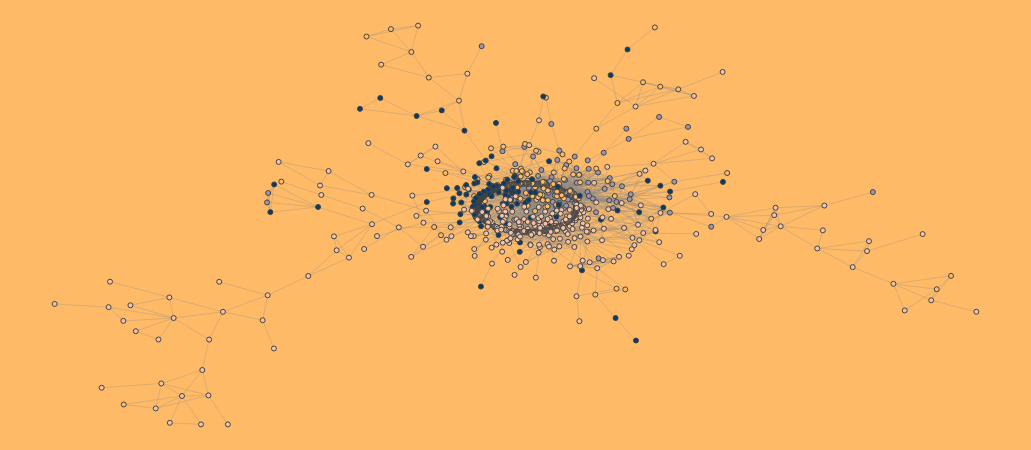

In [193]:
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                 {"plot_bgcolor":"#feba67", "paper_bgcolor":"#feba67", "width":700, "height":450},
                #title='Output of SUNSET prototyp',
                titlefont_size=28,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=0,l=0,r=0,t=0),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),)
                )
fig.show()